In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '..')
from source.base import log_prob, log_prob_unnormalized
import matplotlib as mpl
from source.plot_func import get_ecp, plt_potential_func, plot_evolution
from source.utils import wasserstein2
torch.manual_seed(123)
np.random.seed(123)


### Set distribution variational dits q(x) and target p(x)

In [2]:
mu_p = torch.tensor([0.0, 0.0])
scale_p = torch.tensor([[0.8, 0.4],
                        [0.4, 0.8]])

cov_p = scale_p @ scale_p.T
mu_q = torch.tensor([4.0, 2.0])
scale_q = torch.tensor([[0.8, 0.0000],
                        [0.0, 0.8]])
p = [mu_p, scale_p]
q = [mu_q, scale_q]

def w2_func(mu_q, cov_q):
    return wasserstein2(mu_q, cov_q, mu_p, cov_p)


# Set the banana distribution
from rosenbrock import rosenbrock

mu = torch.Tensor([1.0])
a = torch.Tensor([1.0])
b = torch.ones([2, 1])

p_rosen_dist = rosenbrock.RosenbrockDistribution(mu, a, b)

### 1. OU process

In [3]:

def grad_logp(x, logp):
    return torch.autograd.grad(logp(x), x, grad_outputs=torch.ones_like(logp(x)), 
                               create_graph=False)[0]
    

p_true = torch.distributions.multivariate_normal.MultivariateNormal(mu_p, cov_p)
p_0 = torch.distributions.multivariate_normal.MultivariateNormal(mu_q, scale_q@scale_q.T)
x_0 = p_0.sample([300])


x_t = [x_0.detach()]

x_0.requires_grad=True


# Unadjusted Langevin dynamics step
for i in range(1001):
    x_0 = x_0 + 0.01*grad_logp(x_0, p_true.log_prob) + np.sqrt(0.01*2) * torch.randn_like(x_0)
    x_t.append(x_0.detach())
    
    
mu_t = torch.stack([torch.mean(x_t[i], axis=0) for i in range(len(x_t))])
cov_t = np.stack([np.cov(x_t[i].T) for i in range(len(x_t))])

### 2. BBVI using path-derivative (stl) and reparameterization gradients

In [4]:
def train(q, detach=False, number_iter=1000, lr=0.01, num_monte_grad=5, banana=False):
    
    mu_q, scale_q = q[0].clone(), q[1].clone()
    mu_q.requires_grad = True
    scale_q.requires_grad = True
    opt = torch.optim.SGD([mu_q, scale_q], lr=lr)
    
    
    # Trajectory histories
    mus = np.zeros([number_iter, 2])
    covs = np.zeros([number_iter, 2, 2])
    w2 = []
    
    for i in range(number_iter):
        mu_q_, cov_q_ = mu_q.detach(), scale_q.detach() @ scale_q.detach().T
        
        # Store mu, cov and W2 distance
        mus[i], covs[i] = mu_q_, cov_q_
        opt.zero_grad()
        
        
        # Reparameterization trick
        z = torch.randn([num_monte_grad, 2])
        x = mu_q + z @ scale_q.T
        
        if banana:
            log_p = -p_rosen_dist.nl_pdf(x)
        else:
            log_p = log_prob_unnormalized(mu_p, scale_p, x)
            w2.append(w2_func(mu_q_, cov_q_))
            
        if not detach:
            log_ratio = log_p - log_prob(mu_q, scale_q, x)
        else:
            # Apply the stop gradient operator
            log_ratio = log_p - log_prob(mu_q.detach(), scale_q.detach(), x)
        loss = torch.mean(-log_ratio)  
        loss.backward()
        opt.step()

    return mus, covs, w2

### 3. The forward Euler scheme to the ODE system.

In [5]:
def grad_logp(x, f):
    ## auto grad function
    return torch.autograd.grad(f, x, grad_outputs=torch.ones_like(f), 
                               create_graph=False)[0]

def compute_cov_grad(grad_logr, m):
    #return the gradient for the covariance
    batch_matrix1 = grad_logr[:, np.newaxis, :]
    batch_matrix2 = m[:, np.newaxis, :]
    cov_grad = torch.bmm(batch_matrix1.permute(0, 2, 1), batch_matrix2)+\
                torch.bmm(batch_matrix2.permute(0, 2, 1), batch_matrix1)
    return cov_grad

def train_ode_cov(q, number_iter=1000, lr=0.01, num_monte_grad=5, banana=False):
    mu_q, scale_q = q[0].clone(), q[1].clone()
    
    # Trajectory histories
    cov_q = (scale_q @ scale_q.T)
    mus = np.zeros([number_iter, 2])
    covs = np.zeros([number_iter, 2, 2])
    w2 = []
    for i in range(number_iter):
        mu_q_, cov_q_ = mu_q.detach(), cov_q.detach()
        mus[i], covs[i] = mu_q_, cov_q_
        
        q_dist = torch.distributions.multivariate_normal.MultivariateNormal(mu_q, cov_q)
        x = q_dist.sample([num_monte_grad])
      
        x.requires_grad = True
    
        
        if banana:
            log_p = -p_rosen_dist.nl_pdf(x)
        else:
            log_p = log_prob_unnormalized(mu_p, scale_p, x)
            w2.append(w2_func(mu_q_, cov_q_))
    
        log_ratio = log_p - q_dist.log_prob(x)
        grad_logr = grad_logp(x, log_ratio)
        mu_q = mu_q + lr*grad_logr.mean(0)
        
        grad_cov = compute_cov_grad(grad_logr, x - mu_q)
        cov_q = cov_q + lr*grad_cov.mean(0)
        
    return mus, covs, w2


In [6]:
mus_rep, covs_rep, w2_rep = train(q, detach=False, number_iter=1001, lr=0.01)
mus_path, covs_path, w2_path = train(q, detach=True, number_iter=1001, lr=0.01)
mus_ode, covs_ode, w2_ode = train_ode_cov(q, number_iter=1001, lr=0.01)   


### Plot of trajectories and variances

/home/il19182/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /croot/pytorch_1681837265408/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


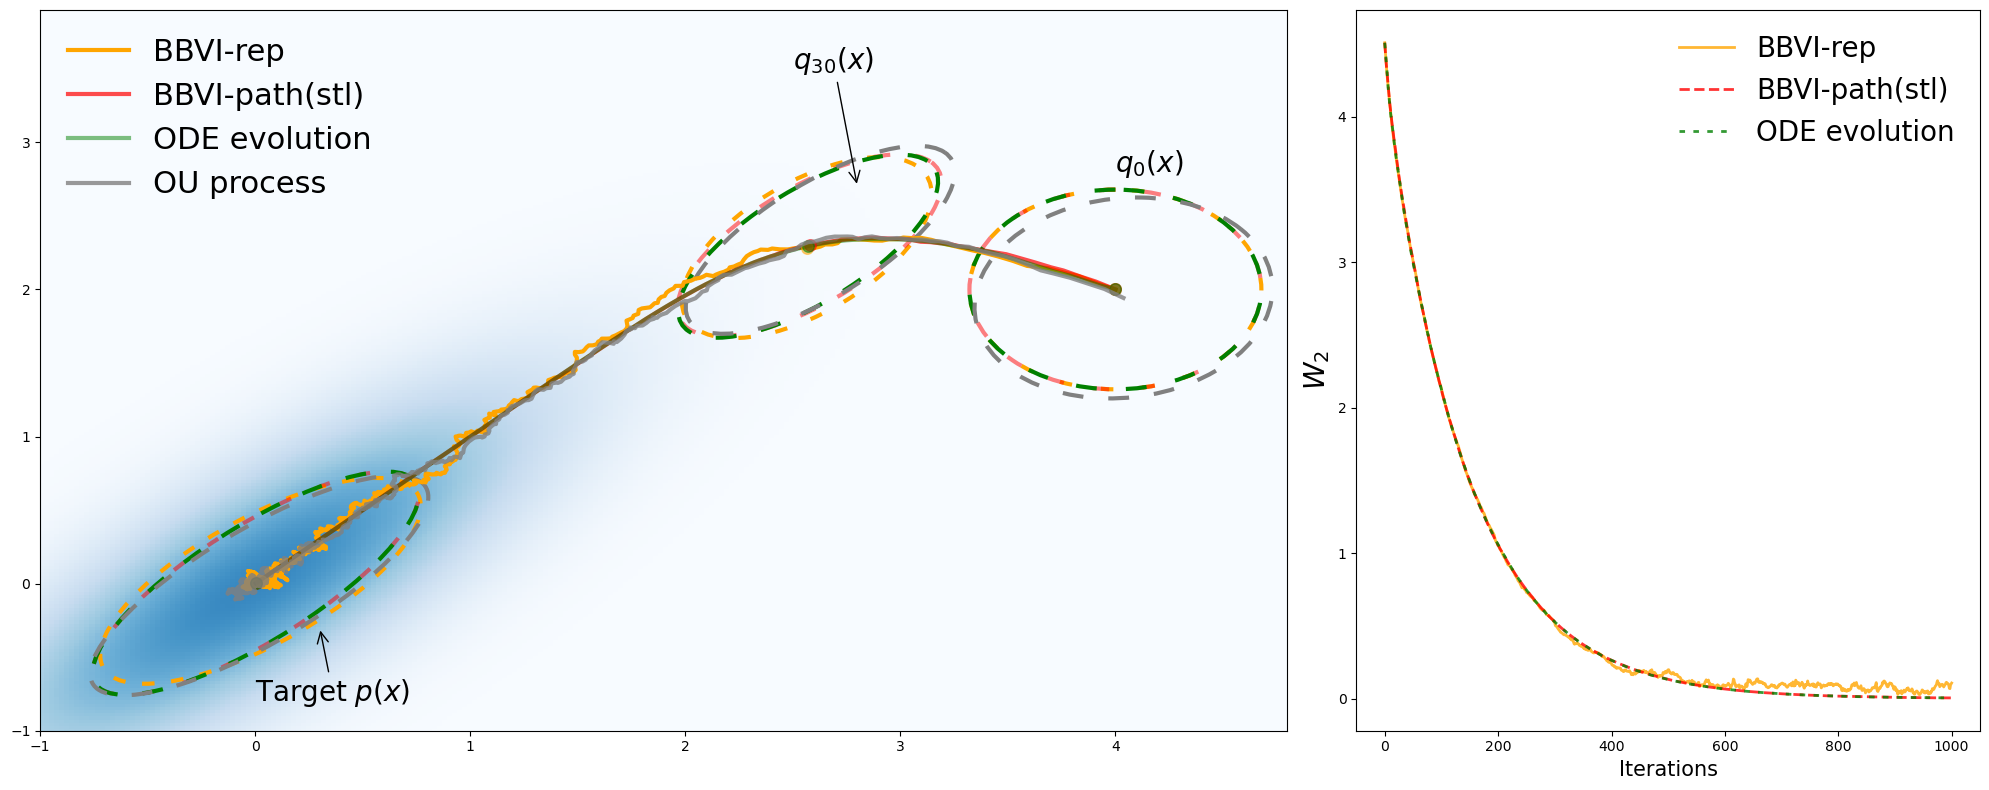

In [7]:

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1.5]}, figsize=(20, 8))

def log_p(x):
    return log_prob_unnormalized(mu_p, scale_p, x)


plt_potential_func(log_p, ax1, cmap='Blues')

ax1.text(4, 2.8, r'$q_{0}(x)$', size=20)
ax1.annotate(r'Target $p(x)$', xy=(0.3, -0.3), xytext=(0.0, -0.8),size=20,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
ax1.annotate(r'$q_{30}(x)$', xy=(2.8, 2.7), xytext=(2.5, 3.5), size=20,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

# Plot the mean trajectories and variances
plot_evolution(mus_rep, mus_path, mus_ode, covs_rep, covs_path, covs_ode, ax1, var_scale=1.2)


# Plot the trajectory and variance ellipsoids for the OU process
ax1.plot(mu_t[:, 0], mu_t[:, 1], linestyle = '-', label='OU process', alpha=0.8,color='grey', linewidth=3)
get_ecp(mu_t[0], cov_t[0] ,ax1, s=1.2, color='grey', style= (0, (5, 6)))
get_ecp(mu_t[30], cov_t[30] ,ax1, s=1.2, color='grey', style= (0, (5, 6)))
get_ecp(mu_t[-1], cov_t[-1] ,ax1, s=1.2, color='grey', style= (0, (5, 6)))

ax1.legend(prop={'size': 22}, loc='upper left', frameon=False)

ax1.set_ylim(-1.0, 3.9)
ax1.set_xlim(-1.0, 4.8)

ax2.plot(w2_rep,'-', label='BBVI-rep', color='orange', alpha=0.8, linewidth=2)
ax2.plot(w2_path,  '--',label='BBVI-path(stl)', color='red', alpha=0.8, linewidth=2)
ax2.plot(w2_ode, linestyle=(0, (2, 3)),label='ODE evolution', color='green', alpha=0.8, linewidth=2)
ax2.legend(prop={'size': 20}, loc='upper right', frameon=False)
ax2.set_xlabel('Iterations', size=15)
ax2.set_ylabel(r'$W_2$', size=20)
fig.tight_layout()

### Increase the size of Monte Carlo gradient to 100

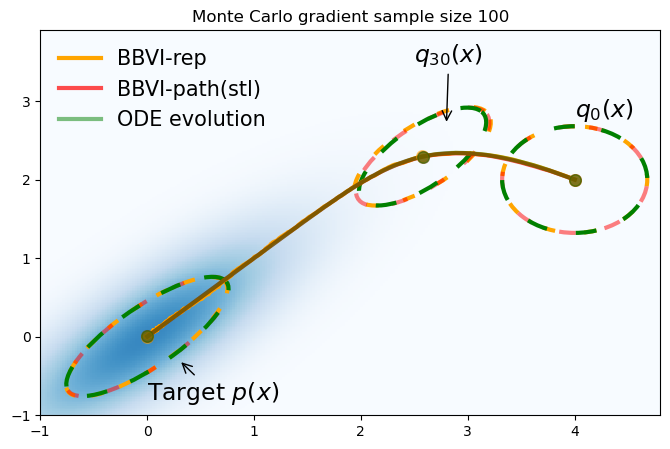

In [8]:
mus_rep, covs_rep, w2_rep = train(q, detach=False, number_iter=1001, lr=0.01, num_monte_grad=100)
mus_path, covs_path, w2_path = train(q, detach=True, number_iter=1001, lr=0.01, num_monte_grad=100)
mus_ode, covs_ode, w2_ode = train_ode_cov(q, number_iter=1001, lr=0.01, num_monte_grad=100)

f, ax1 = plt.subplots(figsize=(8, 5))


plt_potential_func(log_p, ax1, cmap='Blues')

ax1.text(4, 2.8, r'$q_{0}(x)$', size=17)
ax1.annotate(r'Target $p(x)$', xy=(0.3, -0.3), xytext=(0.0, -0.8),size=17,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
ax1.annotate(r'$q_{30}(x)$', xy=(2.8, 2.7), xytext=(2.5, 3.5), size=17,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

# Plot the mean trajectories and variances
plot_evolution(mus_rep, mus_path, mus_ode, covs_rep, covs_path, covs_ode, ax1, var_scale=1.2)

ax1.legend(prop={'size': 15}, loc='upper left', frameon=False)

ax1.set_ylim(-1.0, 3.9)
ax1.set_xlim(-1.0, 4.8)
plt.title('Monte Carlo gradient sample size 100')
plt.show()

### The target dist is the banana distribution

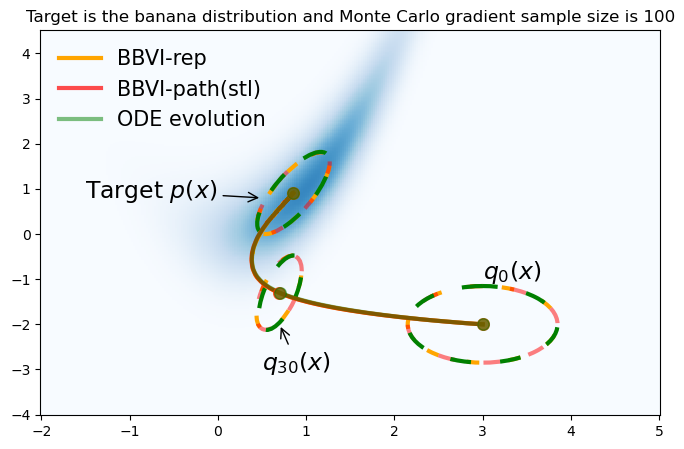

In [9]:
mu_q = torch.tensor([3.0, -2.0])
scale_q = torch.tensor([[1.0000, 0.0000],
                        [0.0, 1.0]])

q = [mu_q, scale_q]

mus_rep, covs_rep, _ = train(q, detach=False, number_iter=4001, lr=0.001, num_monte_grad=100, banana=True)
mus_path, covs_path, _ = train(q, detach=True, number_iter=4001, lr=0.001, num_monte_grad=100, banana=True)
mus_ode, covs_ode, _ = train_ode_cov(q, number_iter=4001, lr=0.001, num_monte_grad=100, banana=True)

f, ax1 = plt.subplots(figsize=(8, 5))

def log_ro(x):
    return -p_rosen_dist.nl_pdf(x)
plt_potential_func(log_ro, ax1, cmap='Blues', ys=[-4, 4.5])

ax1.text(3, -1, r'$q_{0}(x)$', size=17)
ax1.annotate(r'Target $p(x)$', xy=(0.5, 0.8), xytext=(-1.5, 0.8),size=17,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
ax1.annotate(r'$q_{30}(x)$', xy=(0.7, -2.0), xytext=(0.5, -3.0), size=17,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

# Plot the mean trajectories and variances
plot_evolution(mus_rep, mus_path, mus_ode, covs_rep, covs_path, covs_ode, ax1, var_scale=1.2, mid=100)

ax1.legend(prop={'size': 15}, loc='upper left', frameon=False)

plt.title('Target is the banana distribution and Monte Carlo gradient sample size is 100')
plt.show()